In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# import profile data

infile = r'../OOI Biogeochemical Sensor Data Working Group/DATA_FILES_FOR_FIGURES/bio-optics/BioOpticsSource/BO_F6_1_26_JUN_2018_Noon_Profile.csv'
prof = pd.read_csv(infile)

# import bottle data
infile = r'../OOI Biogeochemical Sensor Data Working Group/DATA_FILES_FOR_FIGURES/bio-optics/BioOpticsSource/BO_F6_8_26_JUN_2018_cast_CTD002_Discrete_and_CTD_data.csv'
bot = pd.read_csv(infile)

bot = bot[bot['Discrete Chlorophyll [ug/L]']>0]

# only select the upcast data
idx = prof.index[prof.depth == np.min(prof.depth)]
idx = idx[0].astype('int')

prof_up = prof.iloc[:idx]

prof_up = prof_up.sort_values(by = 'depth')
bot = bot.sort_values(by = 'CTD Depth [m]')

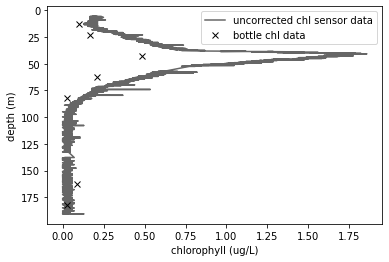

In [4]:
# plot chl sensor and bottle data

plt.plot(prof_up['chlora'], prof_up['depth'],'-k', alpha = 0.6, label = 'uncorrected chl sensor data')
plt.plot(bot['Discrete Chlorophyll [ug/L]'], bot['CTD Depth [m]'], 'xk', label = 'bottle chl data')

ax = plt.gca()
ax.invert_yaxis()

plt.xlabel('chlorophyll (ug/L)')
plt.ylabel('depth (m)')

plt.legend()
plt.show()

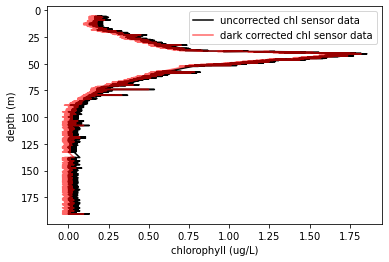

In [5]:
# apply the dark correction

# find the minimum chl value in teh cast
min_chl = prof_up[(prof_up['depth'] > 175)].chlora.median()

prof_up['chlora_dark'] = prof_up['chlora'] - min_chl

# plot chl sensor and dark corrected data

plt.plot(prof_up['chlora'], prof_up['depth'],'-k',label = 'uncorrected chl sensor data')
plt.plot(prof_up['chlora_dark'], prof_up['depth'],'-r', alpha = 0.6, label = 'dark corrected chl sensor data')


ax = plt.gca()
ax.invert_yaxis()

plt.xlabel('chlorophyll (ug/L)')
plt.ylabel('depth (m)')
plt.legend()

plt.show()


/var/folders/1z/b51_h5pj2n37kyl3zp0xnlx80000gn/T/ipykernel_6125/2539173497.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, res, _, _ = np.linalg.lstsq(x, y)


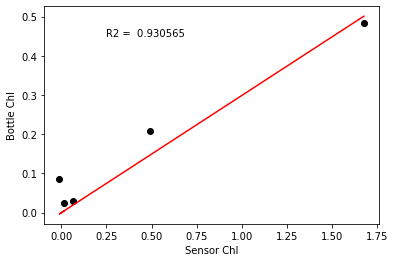

In [56]:
# apply the quenching filter
# find the mixed layer depth


cmax_z = prof_up.depth.loc[cmax].values[0]

filt_prof = prof_up[prof_up.depth > cmax_z]
filt_bot = bot[bot['CTD Depth [m]'] > cmax_z]

# line up bottle data to sensor
prof_match = np.interp(filt_bot['CTD Depth [m]'], filt_prof.depth, filt_prof.chlora_dark)


# plt.plot(bot['Discrete Chlorophyll [ug/L]'], bot['CTD Depth [m]'], 'og')
plt.plot(prof_match, filt_bot['Discrete Chlorophyll [ug/L]'], 'ok')
plt.xlabel('Sensor Chl')
plt.ylabel('Bottle Chl')

# # regression between bottle and sensor data
from scipy import stats
x = prof_match
y = filt_bot['Discrete Chlorophyll [ug/L]']
x = x[:,np.newaxis]

# the intercept is forced through zero in this case
a, res, _, _ = np.linalg.lstsq(x, y)
# calcualte r2 value
r2 = 1 - res / (y.size * y.var())

plt.plot(x, a*x, 'r', label='fitted line')
plt.text(0.25, 0.45, f"R2 =  {r2[0]:.6f}")
plt.show()

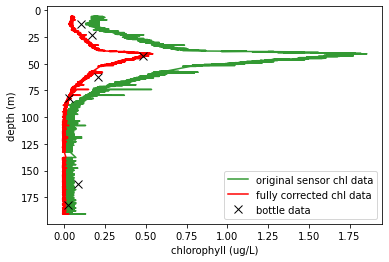

In [57]:
# apply slope and offset correction to sensor data

prof_up['chlora_corr'] = a*prof_up['chlora_dark']

# plot chl sensor and corrected data

plt.plot(prof_up['chlora'], prof_up['depth'],'-g', label = 'original sensor chl data', alpha = 0.8)
plt.plot(prof_up['chlora_corr'], prof_up['depth'],'-r', label = 'fully corrected chl data')
plt.plot(bot['Discrete Chlorophyll [ug/L]'], bot['CTD Depth [m]'], 'xk', markersize = 8, label = 'bottle data')

plt.legend()

ax = plt.gca()
ax.invert_yaxis()

plt.xlabel('chlorophyll (ug/L)')
plt.ylabel('depth (m)')

plt.show()

In [53]:
prof_up


,time,chlora,depth,chlora_dark,chlora_corr
3531,2018-06-26 21:51:59.888759808,0.2023,5.512097,0.1666,0.049754
3540,2018-06-26 21:52:10.045045248,0.2023,5.635109,0.1666,0.049754
3530,2018-06-26 21:51:58.760073728,0.2023,5.640940,0.1666,0.049754
3532,2018-06-26 21:52:01.017464320,0.1904,5.694628,0.1547,0.046200
3533,2018-06-26 21:52:02.146239488,0.1785,5.780316,0.1428,0.042646
...,...,...,...,...,...
15,2018-06-26 20:42:17.150808576,0.0238,190.562905,-0.0119,-0.003554
19,2018-06-26 20:42:21.665509376,0.0476,190.564180,0.0119,0.003554
16,2018-06-26 20:42:18.279480832,0.0357,190.565313,0.0000,0.000000
18,2018-06-26 20:42:20.536818176,0.0000,190.565372,-0.0357,-0.010662
